In [44]:
from cryoS2Sdrop.analyze import *
from cryoS2Sdrop.deconvolution import tom_deconv_tomo
from skimage import exposure

PARENT_PATH = setup.PARENT_PATH

import matplotlib as mpl
mpl.rc("image", cmap="gray")

pd.options.display.float_format = "{:,.6f}".format
pd.set_option('display.max_columns', 50)

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

def make_shell(inner_radius, outer_radius, tomo_shape):
    """
    Creates a (3D) shell with given inner_radius and delta_r width centered at the middle of the array.

    """

    length = min(tomo_shape)
    if length % 2 == 1:
        length = length - 1

    mask_shape = len(tomo_shape) * [length]
    _shell_mask = np.zeros(mask_shape)

    # only do positive quadrant first
    for z in range(0, outer_radius + 1):
        for y in range(0, outer_radius + 1):
            for x in range(0, outer_radius + 1):

                r = np.linalg.norm([z, y, x])

                if r >= inner_radius and r < outer_radius:
                    zidx = z + length // 2
                    yidx = y + length // 2
                    xidx = x + length // 2

                    _shell_mask[zidx, yidx, xidx] = 1

    aux = (
        np.rot90(_shell_mask, axes=(0, 1))
        + np.rot90(_shell_mask, 2, axes=(0, 1))
        + np.rot90(_shell_mask, 3, axes=(0, 1))
    )

    _shell_mask = _shell_mask + aux  # this is half the volume

    aux = np.rot90(
        _shell_mask, 2, axes=(1, 2)
    )  # rotate again 180º to get full volume

    aux2 = _shell_mask + aux

    if inner_radius == 0:
        vol = 4 / 3 * np.pi * outer_radius**3
        pct_diff = (vol - aux2.sum()) / vol
        if pct_diff > 0.1:
            print(pct_diff)
            raise ValueError("Sanity check for sphere volume not passed")

    # finally, fill the actual shape of the tomogram with the mask
    shell_mask = np.zeros(tomo_shape)
    shell_mask[
        (tomo_shape[0] - length) // 2 : (tomo_shape[0] + length) // 2,
        (tomo_shape[1] - length) // 2 : (tomo_shape[1] + length) // 2,
        (tomo_shape[2] - length) // 2 : (tomo_shape[2] + length) // 2,
    ] = aux2

    return shell_mask

def create_hiFreqMask(tomo_shape, fourier_tomo_shape):
    "Randomly mask high frequencies with a sphere"
    inner = 0
    shape_vol = np.array(tomo_shape).prod()
    low_r = (0.05 * 3/(4*np.pi) * shape_vol)**(1/3)
    high_r = (0.1 * 3/(4*np.pi) * shape_vol)**(1/3)
    outer = np.random.uniform(low_r, high_r)
    outer = int(np.round(outer))
    
    shell_mask = make_shell(inner, outer, tomo_shape)
    # up to this point we have a shell for the shifted (centered) full spectrum
    shell_mask = torch.tensor(shell_mask)
    # # make shell correspond to the unshifted spectrum
    # shell_mask = torch.fft.ifftshift(shell_mask)
    # # make it correspond to only real part of spectrum
    # shell_mask = shell_mask[..., 0 : fourier_tomo_shape[-1]]

    return shell_mask.float().numpy()

def create_Vmask(tomo_shape, volumetric_scale_factor):
    "Create volumetric blind spot random mask"
    downsampled_shape = np.array(tomo_shape) // volumetric_scale_factor
    downsampled_shape = tuple(downsampled_shape)

    bernoulli_Vmask = dropoutV(torch.ones(downsampled_shape)) * (
        1 - dropoutV.p
    )
    bernoulli_Vmask = bernoulli_Vmask.unsqueeze(0).unsqueeze(0)
    bernoulli_Vmask = upsample(bernoulli_Vmask)
    
    # adjust for uneven sizes on dimension 0
    diff0 = tomo_shape[0] - bernoulli_Vmask.shape[2]
    if (diff0 > 0) and (diff0 < volumetric_scale_factor):
        extra_row = bernoulli_Vmask[:, :, 0:diff0, ...]
        bernoulli_Vmask = torch.cat([extra_row, bernoulli_Vmask], dim=2)

    return bernoulli_Vmask.squeeze().numpy()

def create_inversionMask(tomo_shape):
    tomo_shape = tuple(tomo_shape)
    bernoulli_Pmask = dropout(torch.ones(tomo_shape)) * (1 - dropout.p)
    bernoulli_Pmask = 2*bernoulli_Pmask - 1

    return bernoulli_Pmask.numpy()

def get_powerSpectrum(fourier_data, scale_data=False):
    power_data = np.log(np.abs(fourier_data)**2)
    if scale_data:
        power_data = scale(power_data)
    else:
        pass
    return power_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


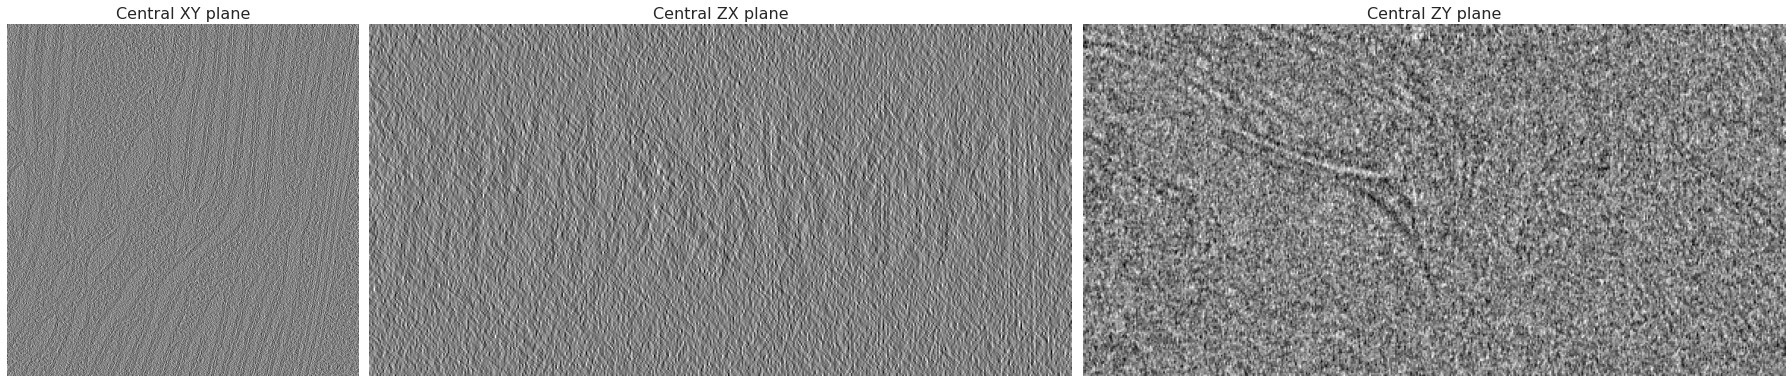

In [43]:
# tomo_name = "tomoPhantom_model14_noisyGaussPoissL"
# tomo_name = "shrec2021_model4_dummy"
tomo_name = "tomo02_dummy"

cet_path, gt_cet_path = parse_tomoPaths(tomo_name)
tomo_data, gt_tomo_data = read_array(cet_path), read_array(gt_cet_path)

tomo_data = standardize(clip(tomo_data))

gt_tomo_data = standardize(clip(gt_tomo_data))

fourier_tomo = np.fft.fftshift(np.fft.fftn(tomo_data))
fourier_tomo_shape = np.array(fourier_tomo.shape)

tomo_shape = np.array(tomo_data.shape)
fig, ax = plot_centralSlices(tomo_data, set_axis_off=True)

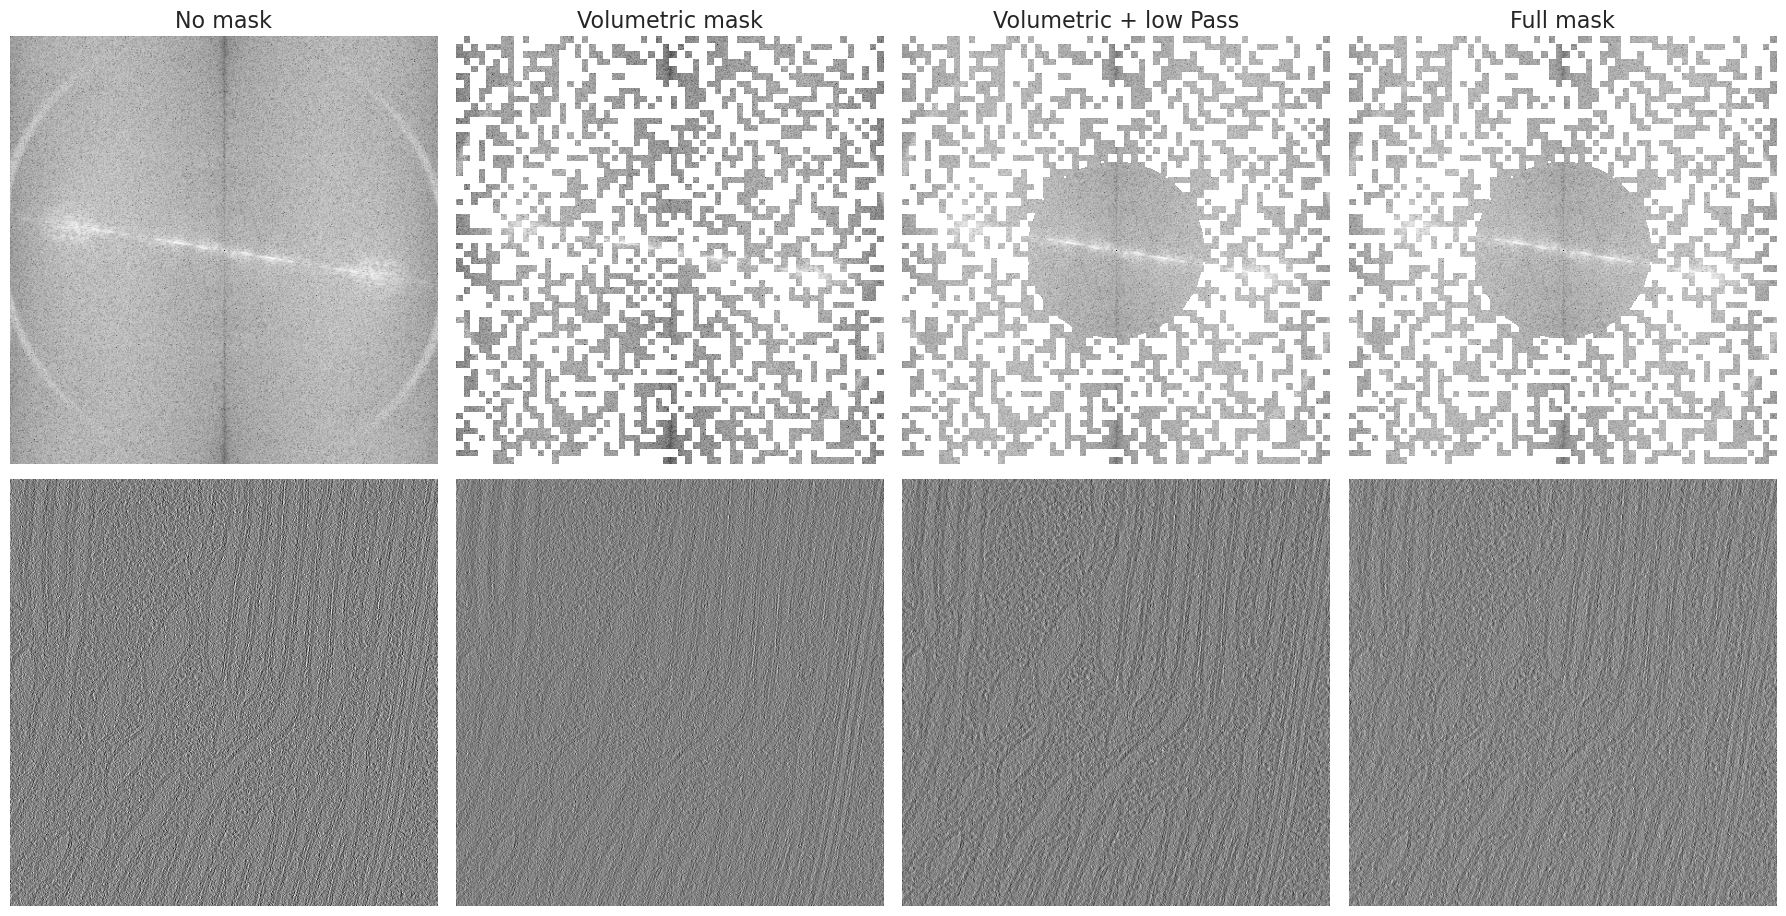

In [45]:
Vmask_pct = 0.5
volumetric_scale_factor = 8

dropoutV = torch.nn.Dropout(p=Vmask_pct)
upsample = torch.nn.Upsample(scale_factor=volumetric_scale_factor)

p = 0.1
dropout = torch.nn.Dropout(p)

fig, ax = plt.subplots(2, 4, figsize=(18, 9), dpi=100)
list(map(lambda axi: axi.set_axis_off(), ax.ravel()))

plt.tight_layout()

idx_central_slices = tomo_shape//2

ax_fourier = ax[0]
ax_real = ax[1]

i = 0
# Original
ax_fourier[0].imshow(np.take(get_powerSpectrum(fourier_tomo), idx_central_slices[i], axis=i))
ax_fourier[0].set_title("No mask", fontsize=16)
ax_real[0].imshow(np.take(tomo_data, idx_central_slices[i], axis=i))

# volumetric mask
Vmask = create_Vmask(tomo_shape, volumetric_scale_factor)

Vmasked_fourier_tomo = fourier_tomo*Vmask

Vmasked_data = np.fft.ifftn(np.fft.ifftshift(Vmasked_fourier_tomo))
Vmasked_data = Vmasked_data.real

ax_fourier[1].imshow(np.take(get_powerSpectrum(Vmasked_fourier_tomo), idx_central_slices[i], axis=i))
ax_fourier[1].set_title("Volumetric mask", fontsize=16)
ax_real[1].imshow(np.take(Vmasked_data, idx_central_slices[i], axis=i))

# vol + lowPass mask
lowPassMask = create_hiFreqMask(tomo_shape, fourier_tomo_shape)
Vol_lowPassMask = Vmask+lowPassMask
Vol_lowPassMask = np.where(Vol_lowPassMask>1, 1, Vol_lowPassMask)

Vol_lowPassMasked_fourier_tomo = fourier_tomo*Vol_lowPassMask

Vol_lowPassMasked_data = np.fft.ifftn(np.fft.ifftshift(Vol_lowPassMasked_fourier_tomo))
Vol_lowPassMasked_data = Vol_lowPassMasked_data.real

ax_fourier[2].imshow(np.take(get_powerSpectrum(Vol_lowPassMasked_fourier_tomo), idx_central_slices[i], axis=i))
ax_fourier[2].set_title("Volumetric + low Pass Mask", fontsize=16)
ax_real[2].imshow(np.take(Vol_lowPassMasked_data, idx_central_slices[i], axis=i))

# full mask
invMask = create_inversionMask(tomo_shape)
fullMask = Vol_lowPassMask*invMask

fullMasked_fourier_tomo = fourier_tomo*fullMask

fullMasked_data = np.fft.ifftn(np.fft.ifftshift(fullMasked_fourier_tomo))
fullMasked_data = fullMasked_data.real

ax_fourier[3].imshow(np.take(get_powerSpectrum(fullMasked_fourier_tomo), idx_central_slices[i], axis=i))
ax_fourier[3].set_title("Volumetric + low Pass + inversion mask", fontsize=16)
ax_real[3].imshow(np.take(fullMasked_data, idx_central_slices[i], axis=i))